In [1]:
import copy
import time as timer
import numpy as np
import pandas as pd

import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from multiprocessing import Pool
from IPython.display import display

import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from lightgbm import LGBMClassifier
from scipy import signal

from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayes_opt import BayesianOptimization

import os
import random

# Fixing the seed
- We always need to ensure the experiments will have the same reults for the same parameters

In [2]:
seed = 41
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Classes And Functions

# Interpolation Methods
- Not all samples will have the same length, so we need to fix this
- There are three options:

a) "repeat"  -> repeating the last row

b) "drop"    -> dropping a fixed size from the end of the signal

c) *specific intepolation method ("linear", "cubic", ...) -> interpolating random parts of the signal

In [3]:
def interpolate_data(sample: pd.DataFrame, to_size: int = 155, method: str = "repeat") -> pd.DataFrame:
    
    current_size = sample.shape[0]
    
    if method == "repeat":
        sample   = sample.values
        last_row = copy.deepcopy(sample[-1])
        last_row = np.expand_dims(last_row, axis = 0)
        last_row = np.repeat(last_row, np.abs(to_size - current_size), axis = 0)
        sample   = np.vstack((sample, last_row))
        sample   = pd.DataFrame(sample, columns = AXIS)
        
    elif method == "drop":
        sample = sample.values[: to_size]
        sample = pd.DataFrame(sample, columns = AXIS)
        
    else:
        
        choices  = np.random.choice(range(10, current_size - 10), np.abs(to_size - current_size), replace = False)
        
        for choice in choices:
            nans = pd.DataFrame({"X": np.nan, "Y": np.nan, "Z": np.nan}, index=[choice])
            sample  = pd.concat([sample.iloc[: (choice - 1)], nans, sample.iloc[(choice - 1):]])
            sample  = sample.reset_index(drop=True)
        
        sample.interpolate(method = method, inplace = True, limit_direction = 'both', limit = to_size)
        
    return sample

# Data loading, using interpolation as default

In [4]:
def load_data(data: pd.DataFrame, length: int, interpolation_method: str = "quadratic") -> pd.DataFrame :
    samples = np.zeros((len(data), length * len(AXIS)))
    labels  = np.zeros((len(data), 1))
    
    for index, row in data.iterrows():
        sample = pd.read_csv(row["Path"], names = AXIS)
        label  = row["Label"]
        
        if sample.shape[0] != length:
            sample = interpolate_data(sample, to_size = length, method = interpolation_method)
            
        sample = np.ravel(sample.T)
        
        samples[index] = sample 
        labels[index] = label
    
    np_data = np.hstack((samples, labels))
    
    names = [ax + "_" + str(t) for ax in AXIS for t in range(length)] + ["Label"]
    data = pd.DataFrame(np_data, columns = names)
    
    return data

# Preprocessing
- This part will be done in three parts:
- Step 1: We apply a butterworth lowpass filter for noise reduction
- Step 2: From the filtered signal will extract the base acceleration and jerk (4th derivative of position)

The base acceleration will be obtained by applying a very restrictive lowpass filter for extracting a basic curve of the signal and jerk represents the derivative of the base acceleration

- Step 3: Feature Extraction stage, will be extracting statistical features from the time domain, the frequency domain and rolling window features on the three signals obtained previously

# Noise Filtering Class (Preprocessing Step 1)
- Applying a lowpass filter on the raw signal

In [5]:
class NoiseFilter:
    def __init__(self, data, cutoff_filter = 45, verbose = None, debug = None):
        self.data = data
        self.cutoff_filter = cutoff_filter
        
        xs = ["X_" + str(t) for t in range(SIGNAL_LENGTH)]
        ys = ["Y_" + str(t) for t in range(SIGNAL_LENGTH)]
        zs = ["Z_" + str(t) for t in range(SIGNAL_LENGTH)]
        
        names = [x for axis in [xs, ys, zs, ["Label"]] for x in axis]
        self.filtered_data = pd.DataFrame(columns = names)
        
        for index, row in self.data.iterrows():

            if verbose is not None and index <= verbose:
                print(20 * "!" + " Sample {} Before filtering ".format(index) + "!" * 20)
                display_signal(row[xs], row[ys], row[zs], method = "2D")

            filtered_xs = NoiseFilter.filter_noise(row[xs], cutoff = self.cutoff_filter)
            filtered_ys = NoiseFilter.filter_noise(row[ys], cutoff = self.cutoff_filter)
            filtered_zs = NoiseFilter.filter_noise(row[zs], cutoff = self.cutoff_filter)
            
            label = self.data["Label"].iloc[index]
            
            if verbose is not None and index <= verbose:
                print(20 * "!" + " Sample {} AFTER filtering ".format(index) + "!" * 20)
                display_signal(filtered_xs, filtered_ys, filtered_zs, method = "2D")
            
            values = [x for axis in [filtered_xs, filtered_ys, filtered_zs, [label]] for x in axis]
            
            self.filtered_data.loc[len(self.filtered_data) + 1] = values
            
            if debug is not None:
                if index == debug:
                    break
                
        self.filtered_data = self.filtered_data.reset_index(drop = True)
                
    # https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
    def butter_lowpass_filter(x, cutoff, nyq_freq, order = 4):
        # Create butter lowpass filter, nyq_freq should be half of the sample rate
        # https://www.youtube.com/watch?v=yWqrx08UeUs
        normal_cutoff = float(cutoff) / nyq_freq
        
        # Get the filter coefficients: numerator and denominator
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        y = signal.filtfilt(b, a, x)
        return y

    def filter_noise(sample, cutoff):
        # Apply first median filter
        return NoiseFilter.butter_lowpass_filter(signal.medfilt(sample), cutoff, SAMPLE_RATE / 2, order = 3)


# Signal Extraction Class (Preprocessing Step 2)

- Deriving the base acceleration and jerk from the filtered signal

In [6]:
class SignalExtractor:
    def __init__(self, data, debug = None):
        self.data = data
        
        xs = ["X_" + str(t) for t in range(SIGNAL_LENGTH)]
        ys = ["Y_" + str(t) for t in range(SIGNAL_LENGTH)]
        zs = ["Z_" + str(t) for t in range(SIGNAL_LENGTH)]
        
        self.features_extracted = pd.DataFrame()
        
        for index, row in self.data.iterrows():
            
            signal_features = pd.DataFrame()
            
            FeatureExtractor(signal_features, row[xs], name = "Raw_Xs")
            FeatureExtractor(signal_features, row[ys], name = "Raw_Ys")
            FeatureExtractor(signal_features, row[zs], name = "Raw_Zs")
            
            base_xs, jerk_xs = SignalExtractor.extract_base_acceleration_and_jerk(row[xs])
            base_ys, jerk_ys = SignalExtractor.extract_base_acceleration_and_jerk(row[ys])
            base_zs, jerk_zs = SignalExtractor.extract_base_acceleration_and_jerk(row[zs])
            
            FeatureExtractor(signal_features, base_xs, name = "Base_Xs")
            FeatureExtractor(signal_features, base_ys, name = "Base_Ys")
            FeatureExtractor(signal_features, base_zs, name = "Base_Zs")
            
            FeatureExtractor(signal_features, jerk_xs, name = "Jerk_Xs")
            FeatureExtractor(signal_features, jerk_ys, name = "Jerk_Ys")
            FeatureExtractor(signal_features, jerk_zs, name = "Jerk_Zs")
            
            #display_signal(base_xs, base_ys, base_zs, method = "2D")
            #display_signal(jerk_xs, jerk_ys, jerk_zs, method = "2D")
            
            magnitude_filt = SignalExtractor.compute_magnitude(row[xs], row[ys], row[zs])
            magnitude_base = SignalExtractor.compute_magnitude(base_xs, base_ys, base_zs)
            magnitude_jerk = SignalExtractor.compute_magnitude(jerk_xs, jerk_ys, jerk_zs)
            
            FeatureExtractor(signal_features, magnitude_filt, name = "Magnitude_Filt")
            FeatureExtractor(signal_features, magnitude_base, name = "Magnitude_Base")
            FeatureExtractor(signal_features, magnitude_jerk, name = "Magnitude_Jerk")
                        
            fft_filt_xs = SignalExtractor.fft(row[xs])
            fft_filt_ys = SignalExtractor.fft(row[ys])
            fft_filt_zs = SignalExtractor.fft(row[zs])
            
            FeatureExtractor(signal_features, fft_filt_xs, name = "FFT_Filt_Xs")
            FeatureExtractor(signal_features, fft_filt_ys, name = "FFT_Filt_Ys")
            FeatureExtractor(signal_features, fft_filt_zs, name = "FFT_Filt_Zs")
                                    
            fft_base_xs = SignalExtractor.fft(base_xs)
            fft_base_ys = SignalExtractor.fft(base_ys)
            fft_base_zs = SignalExtractor.fft(base_zs)
            
            FeatureExtractor(signal_features, fft_base_xs, name = "FFT_Base_Xs")
            FeatureExtractor(signal_features, fft_base_ys, name = "FFT_Base_Ys")
            FeatureExtractor(signal_features, fft_base_zs, name = "FFT_Base_Zs")
            
            fft_jerk_xs = SignalExtractor.fft(jerk_xs)
            fft_jerk_ys = SignalExtractor.fft(jerk_ys)
            fft_jerk_zs = SignalExtractor.fft(jerk_zs)
                        
            FeatureExtractor(signal_features, fft_jerk_xs, name = "FFT_Jerk_Xs")
            FeatureExtractor(signal_features, fft_jerk_ys, name = "FFT_Jerk_Ys")
            FeatureExtractor(signal_features, fft_jerk_zs, name = "FFT_Jerk_Zs")
            
            fft_magnitude_filt = SignalExtractor.fft(magnitude_filt)
            fft_magnitude_base = SignalExtractor.fft(magnitude_base)
            fft_magnitude_jerk = SignalExtractor.fft(magnitude_jerk)
            
            FeatureExtractor(signal_features, fft_magnitude_filt, name = "FFT_Magnitude")
            FeatureExtractor(signal_features, fft_magnitude_base, name = "FFT_Magnitude_Base")
            FeatureExtractor(signal_features, fft_magnitude_jerk, name = "FFT_Magnitude_Jerk")
            
            label = pd.Series(row["Label"])
            signal_features["Label"] = label
            
            self.append_features(signal_features)
            
            if debug is not None:
                if index == debug:
                    break
    
    def append_features(self, features):
        self.features_extracted = pd.concat([self.features_extracted, features], axis = 0)
        self.features_extracted = self.features_extracted.reset_index(drop = True)
        
    
    # To extract base acceleration apply a restrictive filter
    # To extract jerk will derive the acceleration (base)
    def extract_base_acceleration_and_jerk(x):
        BUTTER_CUTOFF = 0.5
        base = NoiseFilter.butter_lowpass_filter(x, BUTTER_CUTOFF, SAMPLE_RATE / 2, order = 3)
        
        def derive(signal):
            return np.diff(signal) / (DELTA / len(signal))
        
        jerk = derive(base)
        
        return base, jerk
    
    def compute_magnitude(xs, ys, zs):
        x = [np.linalg.norm(vector) for vector in zip(xs, ys, zs)]
        return np.array(x)


    def fft(x):
        return np.array(abs(np.fft.rfft(x)))

# Feature Extraction (Preprocessing Step 3)
- Extracting various statistical features from the filtered signal, base acceleration and jerk 

In [7]:
def FeatureExtractor(data, sample, name):
    
    import warnings
    warnings.filterwarnings("ignore")

    def hann_mean(a):
        from scipy.signal import hann, convolve
        return (convolve(a, hann(10), mode='same') / sum(hann(10))).mean()

    def hilbert_mean(a):
        from scipy.signal import hilbert
        return np.abs(hilbert(a)).mean()

    def add_trend_feature(a, apply_abs = False):
        from sklearn.linear_model import LinearRegression
        idx = np.arange(len(a))
        lr = LinearRegression()
        lr.fit(idx.reshape(-1, 1), a if not apply_abs else np.abs(a))
        return lr.coef_[0]

    def entropy(a):
        import scipy.stats
        return scipy.stats.entropy(a)

    def trim_mean(a, coef):
        from scipy.stats import trim_mean
        return trim_mean(a, coef)
    
    def IQR(a):
        from scipy.stats import iqr
        return iqr(a)
    
    def wrap(x):
        return pd.Series(x)
    
    
    sample = pd.Series(sample)
    
    data["Last_" + name]   = wrap(sample.values[-1])
    data["Mean_" + name]   = wrap(sample.mean())
    data["Std_" + name]    = wrap(sample.std())
    data["Median_" + name] = wrap(sample.median())
    
    data["Max_" + name] = wrap(sample.max())
    data["Min_" + name] = wrap(sample.min())
    
    data["IQR_" + name] = wrap(IQR(sample))
    data["Skew_" + name] = wrap(sample.skew())
    data["Kurtosis_" + name] = wrap(sample.kurtosis())
    
    data["Mad_" + name] = wrap(sample.mad())
    data["Sum_" + name] = wrap(sample.sum())
    data["Mean_Change_" + name] = wrap(np.mean(np.diff(sample)))
    data["Energy_" + name] = wrap(sample.pow(2).sum() / sample.count())
    data["Q01_" + name] = wrap(np.quantile(sample, 0.01))
    data["Q05_" + name] = wrap(np.quantile(sample, 0.05))
    data["Q90_" + name] = wrap(np.quantile(sample, 0.90))
    data["Q95_" + name] = wrap(np.quantile(sample, 0.95))
    
    
    data["Trend_" + name] = wrap(add_trend_feature(sample))
    data["Trend_Abs_" + name] = wrap(add_trend_feature(sample, True))
    data["Entropy_" + name] = wrap(entropy(sample))
    data["Hilbert_Mean_" + name] = wrap(hilbert_mean(sample))
    data["Hamm_Mean_" + name] = wrap(hann_mean(sample))
    
    for coef in [0.1, 0.3]:
        data[f"Trim_Mean_{coef}_{name}"] = wrap(trim_mean(sample, coef))
        
    for window in [5, 10, 20]:
        data[f"Rolling_Mean_{window}_{name}"] = wrap(sample.rolling(window = window).mean().mean(skipna = True))
        data[f"Rolling_Mean_{window}_{name}"] = wrap(sample.rolling(window = window).mean().mean(skipna = True))
        data[f"Exp_Mov_Avr_{window}_{name}"] = wrap(pd.Series.ewm(sample, span = window).mean()).mean(skipna = True)
        
    return data

- The code below was used for visualizing different features extracted from signals

In [8]:
# xs = ["X_" + str(t) for t in range(SIGNAL_LENGTH)]
# ys = ["Y_" + str(t) for t in range(SIGNAL_LENGTH)]
# zs = ["Z_" + str(t) for t in range(SIGNAL_LENGTH)]

# sample_x, sample_y, sample_z = filtered_data[xs].values[0], filtered_data[ys].values[0], filtered_data[zs].values[0]

# display_signal(sample_x, sample_y, sample_z, method = "2D")

# from scipy.signal import hann, convolve
# from scipy.signal import hilbert

# hann_coef = 20

# mod_x = convolve(sample_x, hann(hann_coef), mode='same') / sum(hann(hann_coef))
# mod_y = convolve(sample_y, hann(hann_coef), mode='same') / sum(hann(hann_coef))
# mod_z = convolve(sample_z, hann(hann_coef), mode='same') / sum(hann(hann_coef))

# display_signal(mod_x, mod_y, mod_z, method = "2D")

# Sanity Check for Dataframe
- Some features extracted will result in nan or infinite values, those will be removed from the data

In [9]:
def drop_na_or_inf_features(data: pd.DataFrame) -> pd.DataFrame:
    too_big = [f for f in data.columns.to_series()[(np.isinf(data).any())]]
    too_nan = [f for f in data.columns.to_series()[(np.isnan(data).any())]]
    
    to_remove = too_big + too_nan
    
    removed = data.drop(to_remove, axis = 1, inplace = False)
    return removed

In [10]:
def display_correlation_matrix(data: pd.DataFrame) -> None:
    plt.figure(figsize = (15, 15))
    
    matrix = np.triu(data.corr())
    
    sns.heatmap(data.corr(), mask = matrix, vmin = -1, vmax = 1, center = 0)
    
    plt.show()

# Dropping High Correlated Features
- Correlated features may lead in redundancy in data, meaning that sometimes there is no new information that can be extracted or learned from it.. so well remove the features that are correlated above some threshold 

In [11]:
def drop_highly_correlated_predictions(data, threshold = 0.99, drop = True, verbose = False):

    corr_matrix = data.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Length Classifiers to drop for Threshold {str(threshold)}: {len(to_drop)}")
    
    if verbose:
        print("Features to drop for Threshold " + str(threshold), to_drop)
    
    if drop:
         data = data.drop(data[to_drop], axis = 1, inplace = False)
    
    return data

In [12]:
def drop_highly_correlated_features(data: pd.DataFrame, correlation_threshold: float = 0.99, drop_percentage: float = 0.7, verbose: bool = False):
    corr_matrix = data.corr().abs()
    
    corrs = {}
    for row in corr_matrix.index:
        corrs[row] = 0
        for column in corr_matrix.columns:
            if row != column:
                if corr_matrix[row][column] > correlation_threshold:
                    corrs[row] += 1
    
    corrs = {key: value for key, value in sorted(corrs.items(), key = lambda item: item[1], reverse = True) if value >= 1}
        
    if verbose:
        print("Frequency of correlation")
        display(corrs)
        
    threshold_values = int(drop_percentage * len(corrs))
    
    to_drop = [key for (idx, key) in enumerate(corrs.keys()) if idx < threshold_values]
    
    print(f"Length Features to drop for Threshold {str(correlation_threshold)}: {len(to_drop)}")
    
    data = data.drop(data[to_drop], axis = 1, inplace = False)
    
    return data

# Procedure to display signal samples

In [13]:
def display_signal(xs, ys, zs, method = "3D"):

    assert method in ["2D", "3D"], "Wrong Method"
    
    if method == "3D":
        
        fig = plt.figure(figsize = (10, 8))
        ax = Axes3D(fig)
        ax.scatter(xs, ys, zs)
    else:
            
        %matplotlib inline

        time = [s for s in range(len(xs))] 
        fig = plt.figure(figsize = (14, 10))
        
        plt.subplot(3, 1, 1)
        plt.plot(time, list(xs), '.-')
        plt.title('A tale of 3 subplots')
        plt.ylabel('Xs')

        plt.subplot(3, 1, 2)
        plt.plot(time, list(ys), '.-')
        plt.xlabel('Time (s)')
        plt.ylabel('Ys')

        plt.subplot(3, 1, 3)
        plt.plot(time, list(zs), '.-')
        plt.xlabel('Time (s)')
        plt.ylabel('Zs')
    
    plt.show()

# Define constants and paths

In [14]:
DEBUG = None
FOLDS = 5
DELTA = 1.6
SAMPLE_RATE = 100

SIGNAL_LENGTH = 160
TRAIN_SAMPLES = 9000
TEST_SAMPLES  = 5000

AXIS = ["X", "Y", "Z"]


PATH_TO_INPUT = "dataset/"

PATH_TO_TRAIN  = PATH_TO_INPUT + "train/"
PATH_TO_TEST   = PATH_TO_INPUT + "test/"

PATH_TO_LABELS = PATH_TO_INPUT + "train_labels.csv"
PATH_TO_SUBMIS = PATH_TO_INPUT + "sample_submission.csv"

In [15]:
train = pd.read_csv(PATH_TO_LABELS)
train.columns = ["Id", "Label"]
train["Path"] = train["Id"].apply(lambda x : PATH_TO_TRAIN + str(x) + ".csv")

test  = pd.read_csv(PATH_TO_SUBMIS)
test.columns = ["Id", "Label"]
test["Path"] = test["Id"].apply(lambda x : PATH_TO_TEST + str(x) + ".csv")

# Label Distribution
 - Usually a good practice is to check from the start the labels distribution.

If the dataset is imbalanced we might use subsampling, upsampling or clustering. For this problem won't be necessary because we have a uniform distribution of the classes

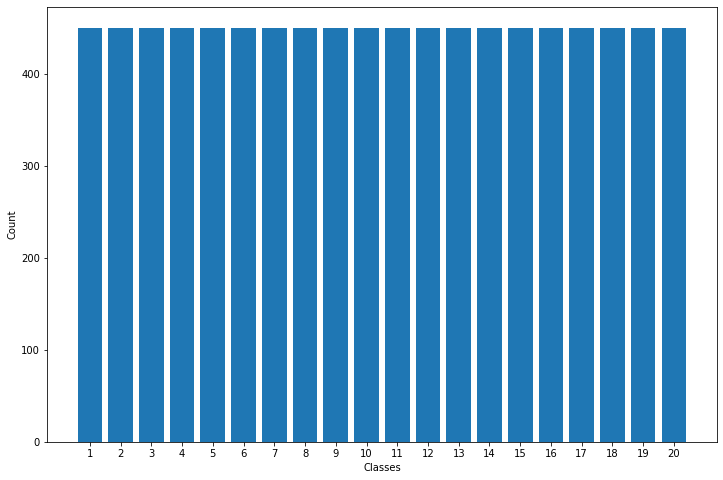

In [16]:
classes, counts = np.unique(train["Label"].values, return_counts=True)

plt.figure(figsize = (12, 8))
plt.bar(classes, counts, align='center')
plt.gca().set_xticks(classes)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

# Load and Interpolate Dataset

In [17]:
tic = timer.time()
train_data = load_data(train, length = SIGNAL_LENGTH, interpolation_method = "quadratic")
test_data  = load_data(test,  length = SIGNAL_LENGTH, interpolation_method = "quadratic")
toc = timer.time()
print("Time to load {}'s'".format(toc - tic))

Time to load 218.83487629890442's'


# Sanity Check for nan or infinite values

In [18]:
sanity_check = lambda x : (x.isnull().values.any() or np.isinf(x.values).any())

In [19]:
display(train_data)

print("Check NaN or Inf values on Train: ", sanity_check(train_data))
print("Check NaN or Inf values on Test: ", sanity_check(test_data))

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,Z_151,Z_152,Z_153,Z_154,Z_155,Z_156,Z_157,Z_158,Z_159,Label
0,-0.767342,-0.826000,-0.819415,-0.809240,-0.798466,-0.762553,-0.725443,-0.667384,-0.653617,-0.694318,...,7.903260,7.908647,8.006210,8.165425,8.464102,8.534132,8.619724,8.650849,8.673594,7.0
1,-1.105523,-1.020528,-0.965462,-0.936133,-0.899023,-0.867898,-0.799065,-0.693121,-0.592565,-0.477045,...,8.426991,8.471883,8.613141,8.693346,8.887277,8.892664,8.777742,8.763975,8.886678,13.0
2,-0.226252,-0.229245,-0.232836,-0.251391,-0.245406,-0.202310,-0.172981,-0.194529,-0.210690,-0.181361,...,7.560889,7.694365,7.967305,8.182783,8.280347,8.316259,8.245630,8.069656,7.870339,6.0
3,0.183156,0.296881,0.400430,0.470461,0.543484,0.544082,0.530316,0.499790,0.490811,0.486621,...,7.858967,8.526351,8.684368,8.723872,8.652046,8.614936,8.642469,8.581417,8.485051,1.0
4,-0.091578,0.079009,0.205303,0.236427,0.235829,0.214281,0.230442,0.253187,0.295085,0.319027,...,8.226477,8.333019,8.598776,8.811859,8.914810,8.972870,8.971672,8.886678,8.710705,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.074819,0.003591,0.070030,0.224456,0.194529,0.316035,0.638653,0.865504,0.936133,0.925359,...,7.857171,7.357382,6.549937,6.311116,6.297947,6.542156,6.966528,7.190985,7.251439,20.0
8996,-0.041300,0.005986,0.044891,0.125696,0.193930,0.307056,0.328604,0.274136,0.161010,-0.044293,...,8.197148,8.052897,7.924209,7.835624,7.788937,7.854179,7.927202,7.873333,7.749433,2.0
8997,0.821211,0.562039,0.484227,0.332794,0.170587,0.009577,-0.139462,-0.254384,-0.319027,-0.345962,...,10.137649,10.206482,10.188525,10.040684,9.782708,9.386468,8.912415,8.422203,7.983466,3.0
8998,0.604536,0.350152,0.344166,0.430358,0.610521,0.706888,0.815824,0.878073,0.890045,0.886453,...,8.414422,7.944560,7.740454,8.096592,7.961319,7.772776,7.662044,7.608773,7.653664,3.0


Check NaN or Inf values on Train:  False
Check NaN or Inf values on Test:  False


# Visualizing the raw signals

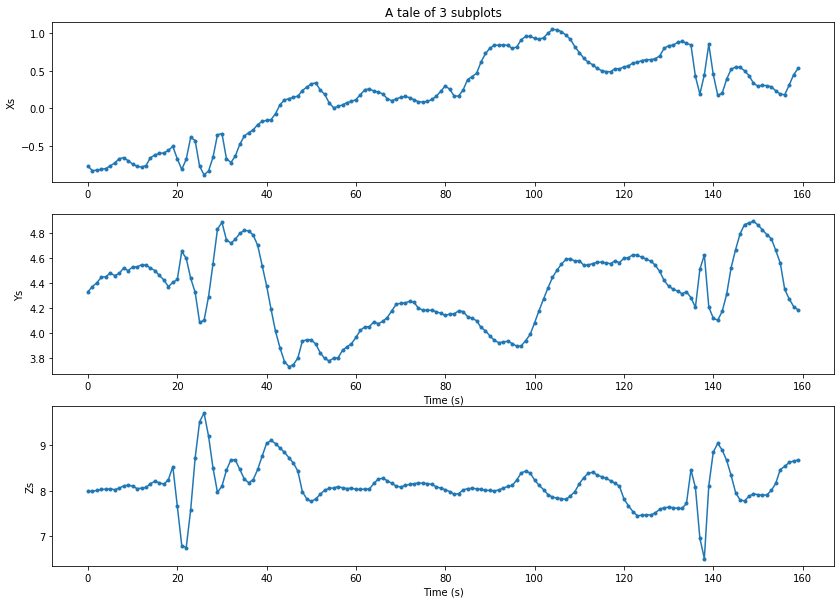

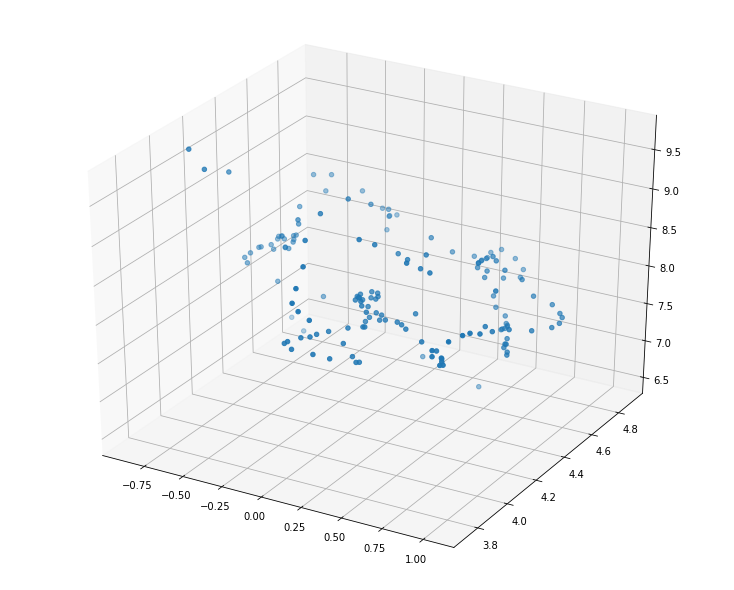

In [20]:
POINT = 0

xs = ["X_" + str(t) for t in range(SIGNAL_LENGTH)]
ys = ["Y_" + str(t) for t in range(SIGNAL_LENGTH)]
zs = ["Z_" + str(t) for t in range(SIGNAL_LENGTH)]

sample_x, sample_y, sample_z = train_data[xs].values[POINT], train_data[ys].values[POINT], train_data[zs].values[POINT]

display_signal(sample_x, sample_y, sample_z, method = "2D")

display_signal(sample_x, sample_y, sample_z, method = "3D")

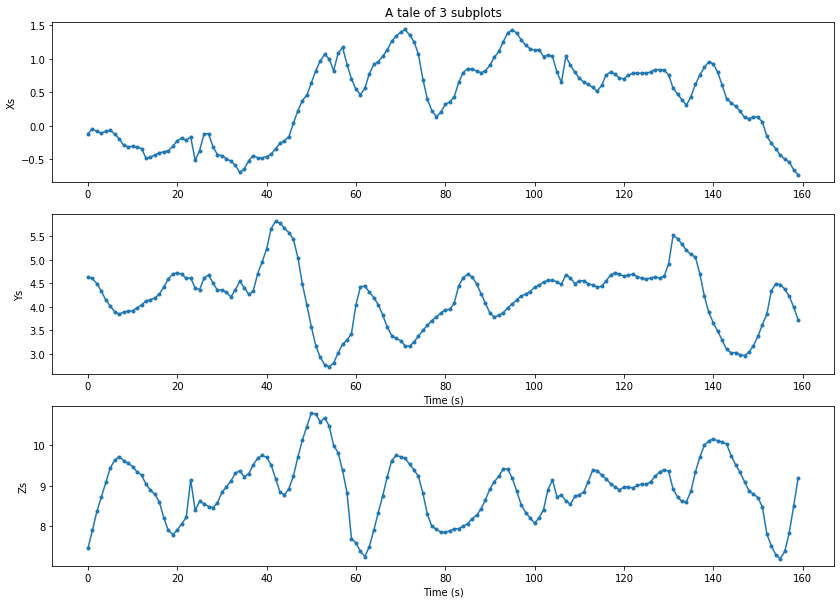

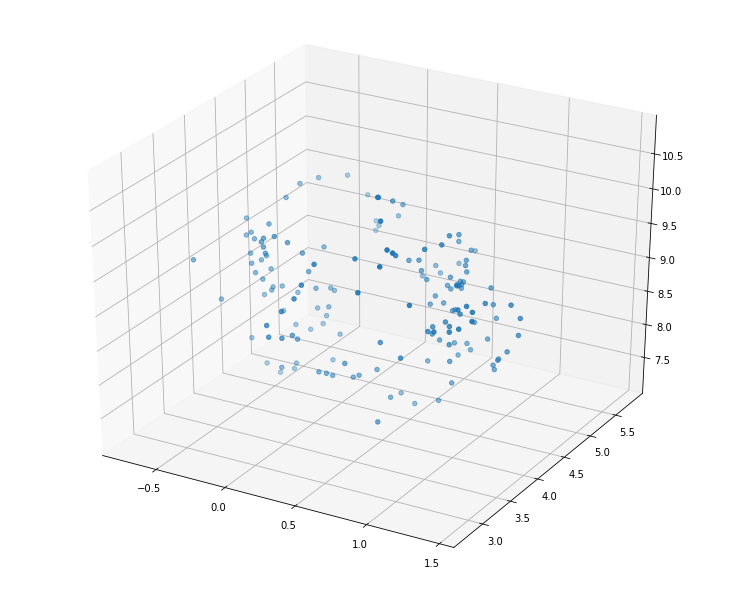

In [21]:
POINT = 50

xs = ["X_" + str(t) for t in range(SIGNAL_LENGTH)]
ys = ["Y_" + str(t) for t in range(SIGNAL_LENGTH)]
zs = ["Z_" + str(t) for t in range(SIGNAL_LENGTH)]

sample_x, sample_y, sample_z = train_data[xs].values[POINT], train_data[ys].values[POINT], train_data[zs].values[POINT]

display_signal(sample_x, sample_y, sample_z, method = "2D")

display_signal(sample_x, sample_y, sample_z, method = "3D")

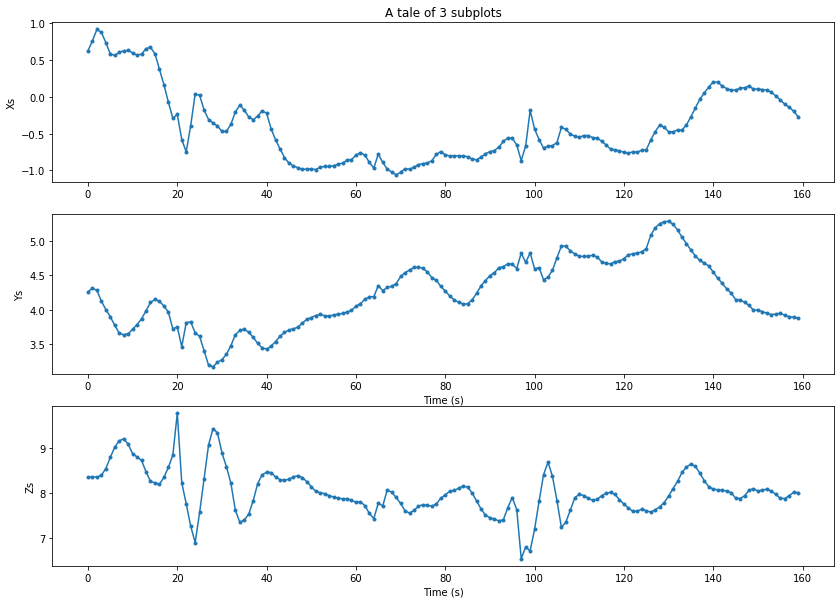

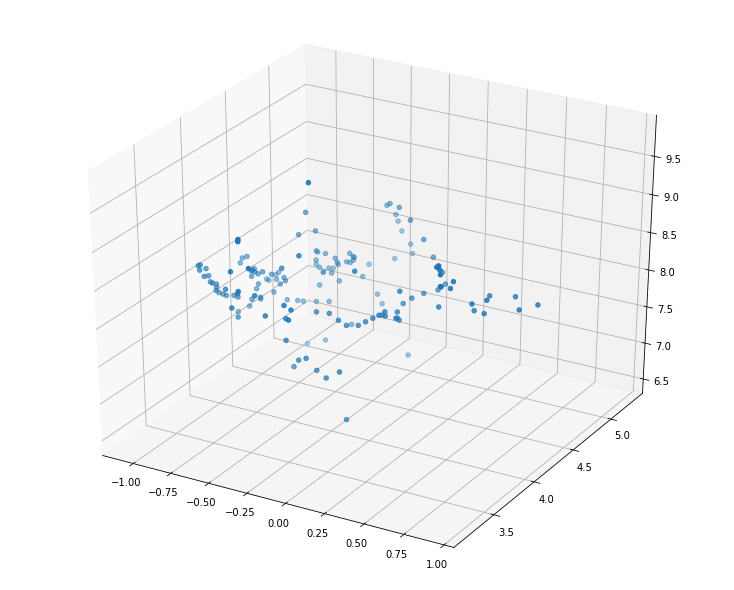

In [22]:
POINT = 100

xs = ["X_" + str(t) for t in range(SIGNAL_LENGTH)]
ys = ["Y_" + str(t) for t in range(SIGNAL_LENGTH)]
zs = ["Z_" + str(t) for t in range(SIGNAL_LENGTH)]

sample_x, sample_y, sample_z = train_data[xs].values[POINT], train_data[ys].values[POINT], train_data[zs].values[POINT]

display_signal(sample_x, sample_y, sample_z, method = "2D")

display_signal(sample_x, sample_y, sample_z, method = "3D")

# Fixing Folds 
- Will be done only once

In [23]:
train_data.loc[:, "Fold"] = -1
# train_data = train_data.sample(frac = 1).reset_index(drop = True)

features = train_data.drop("Label", axis = 1, inplace = False).values
labels   = train_data["Label"].values

skf = StratifiedKFold(n_splits = FOLDS)
for fold, (train_idx, valid_idx) in enumerate(skf.split(features, labels)):  
    train_data.loc[valid_idx, "Fold"] = fold
    
# train_data.to_csv("folds.csv", index = False)
folds = train_data["Fold"].values

# Training a baseline model on the raw data

In [24]:
features = train_data.drop(["Label", "Fold"], axis = 1).values
labels   = train_data["Label"].values 

y_oof  = np.zeros((features.shape[0], 1))
y_true = np.zeros((features.shape[0], 1))
scores_oof = np.zeros((FOLDS, 1))

tic = timer.time()

for fold in range(FOLDS):    
    print(20 * "!" + " FOLD {} ".format(fold + 1) + "!" * 20)
    train_idx = train_data[train_data.Fold != fold].index.values
    valid_idx = train_data[train_data.Fold == fold].index.values
    
    X_train, y_train = features[train_idx], labels[train_idx]
    X_valid, y_valid = features[valid_idx], labels[valid_idx]
    
    model = LGBMClassifier(n_estimators = 200, n_jobs = -1, random_state = seed)
    model.fit(X_train, y_train)
    
    y_predict = model.predict(X_valid)
    
    y_oof[valid_idx]  = copy.deepcopy(np.expand_dims(y_predict, axis = 1))
    y_true[valid_idx] = copy.deepcopy(np.expand_dims(y_valid, axis = 1))

    accuracy = accuracy_score(y_predict, y_valid)
        
    scores_oof[fold] = accuracy 

toc = timer.time()
print("Time to train {}'s'".format(toc - tic))

baseline_preds = copy.deepcopy(y_oof)

!!!!!!!!!!!!!!!!!!!! FOLD 1 !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 2 !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 3 !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 4 !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 5 !!!!!!!!!!!!!!!!!!!!
Time to train 310.6401650905609's'


# Initial Scores

In [25]:
print("Out of fold accuracy {}, Standard deviation oof scores {}" \
      .format(np.round(accuracy_score(y_true, y_oof), 4), \
              np.round(scores_oof.std(), 4)))

Out of fold accuracy 0.8689, Standard deviation oof scores 0.0044


# Results Analysis
# Predictions Distribution, Confusion Matrix, Classification report

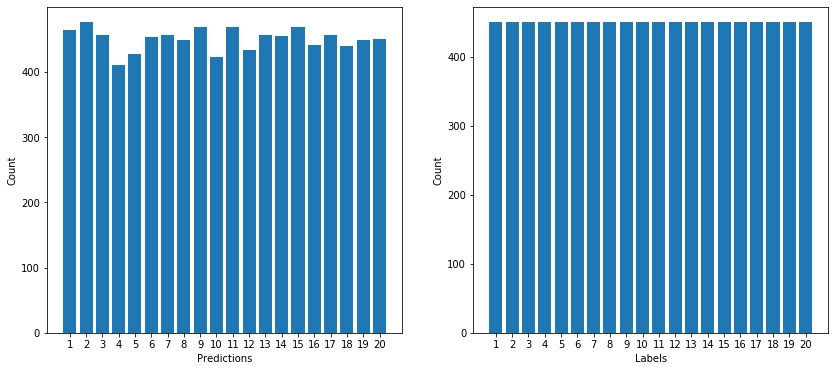

In [26]:
preds  , counts_preds = np.unique(y_oof, return_counts=True)
classes, counts_class = np.unique(y_true, return_counts=True)

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax1.bar(preds, counts_preds, align='center')
plt.gca().set_xticks(classes)
plt.xlabel("Predictions")
plt.ylabel("Count")

ax2 = fig.add_subplot(122)
ax2.bar(classes, counts_class, align='center')
plt.gca().set_xticks(classes)
plt.xlabel("Labels")
plt.ylabel("Count")

plt.show()

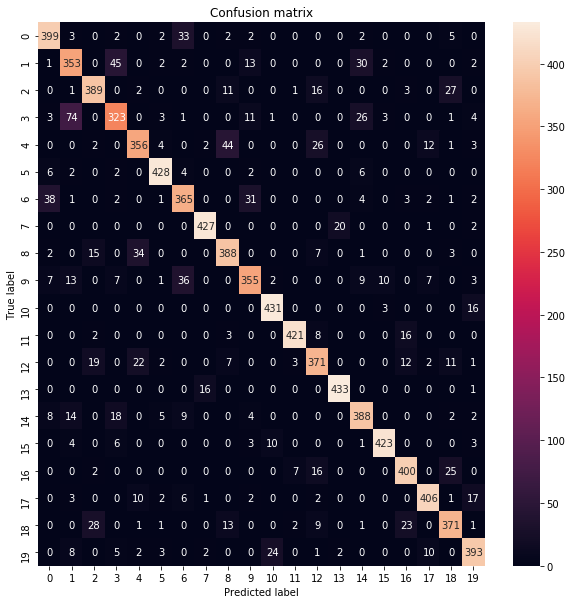

In [27]:
cm = confusion_matrix(y_true, y_oof)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [28]:
print(classification_report(y_true, y_oof))

              precision    recall  f1-score   support

         1.0       0.86      0.89      0.87       450
         2.0       0.74      0.78      0.76       450
         3.0       0.85      0.86      0.86       450
         4.0       0.79      0.72      0.75       450
         5.0       0.83      0.79      0.81       450
         6.0       0.94      0.95      0.95       450
         7.0       0.80      0.81      0.81       450
         8.0       0.95      0.95      0.95       450
         9.0       0.83      0.86      0.85       450
        10.0       0.84      0.79      0.81       450
        11.0       0.92      0.96      0.94       450
        12.0       0.97      0.94      0.95       450
        13.0       0.81      0.82      0.82       450
        14.0       0.95      0.96      0.96       450
        15.0       0.83      0.86      0.85       450
        16.0       0.96      0.94      0.95       450
        17.0       0.88      0.89      0.88       450
        18.0       0.92    

# Adversarial Validation for train and test set
- This procedure is a specific way to ensure not only if the train and test distributions are the same, this allows us the check if two subsets of a dataset or a dataset with the same features are alike

For this experiment will use the AUC Metric (Area Under the Curve) will train a binary classification model for distinguishing between the train and test set, will set the labels for the training set as zero and for testing set as one.

If there are no big differences between datasets the model predictions will be close to random, meaning the AUC Score will be close to 50%, but if there are differences between those two sets, then the classifier is able to see the patterns for each set. This might give us an idea if the score from the public leaderboard will aligned with the one from the private leaderboard.

From my experience any score above 65% on this task of binary classification means that those two datasets weren't sampled well and we might expect big differences in the private leaderboard score.



In [29]:
train_copy = copy.deepcopy(train_data)
test_copy  = copy.deepcopy(test_data)

train_copy.drop(["Fold"], axis = 1, inplace = True)

train_copy["Label"] = 0
test_copy["Label"]  = 1

adversarial_data = pd.concat([train_copy, test_copy], axis = 0)
adversarial_data = adversarial_data.sample(frac=1).reset_index(drop=True)

adversarial_train = adversarial_data.drop("Label", axis = 1, inplace = False).values
adversarial_label = adversarial_data['Label'].values

In [30]:
train, test, y_train, y_test = train_test_split(adversarial_train, adversarial_label, test_size = 0.2, random_state = seed, shuffle=True)

In [31]:
train = lgb.Dataset(train, label = y_train)
test = lgb.Dataset(test, label = y_test)

In [32]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.05,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": seed,
         "seed": seed,
         "metric": 'auc',
         "verbosity": -1}

In [33]:
num_round = 2000
clf = lgb.train(param, train, num_round, valid_sets = [train, test], verbose_eval=50, early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds
[50]	training's auc: 0.799399	valid_1's auc: 0.68059
[100]	training's auc: 0.879254	valid_1's auc: 0.704989
[150]	training's auc: 0.921121	valid_1's auc: 0.716298
[200]	training's auc: 0.946206	valid_1's auc: 0.722433
[250]	training's auc: 0.96262	valid_1's auc: 0.730085
[300]	training's auc: 0.973532	valid_1's auc: 0.737915
[350]	training's auc: 0.981703	valid_1's auc: 0.741197
[400]	training's auc: 0.987499	valid_1's auc: 0.742544
[450]	training's auc: 0.991463	valid_1's auc: 0.74399
[500]	training's auc: 0.994169	valid_1's auc: 0.748691
[550]	training's auc: 0.995938	valid_1's auc: 0.751627
[600]	training's auc: 0.997153	valid_1's auc: 0.754755
[650]	training's auc: 0.9981	valid_1's auc: 0.754514
[700]	training's auc: 0.998677	valid_1's auc: 0.755239
[750]	training's auc: 0.999089	valid_1's auc: 0.755821
[800]	training's auc: 0.999425	valid_1's auc: 0.757645
[850]	training's auc: 0.999594	valid_1's auc: 0.761849
[900]	tra

# It seems that train and test set are quite different
- The AUC score 0.775 means that our classifier is able to distinguish the train and test set
- From now on, because of this score, and more important, we have no way of verifying our approach on the test set, will use only oof score (out of fold) assuming that our cross-validation would have been aligned with the leaderboard

# Preprocessing Part
- Extracting the folds first

# Noise Filtering

In [34]:
folds = train_data["Fold"].values
train_data = train_data.drop(["Fold"], axis = 1, inplace = False)

tic = timer.time()
filtered_data = NoiseFilter(train_data, cutoff_filter = 10, verbose = None, debug = DEBUG).filtered_data
toc = timer.time()
print("Time to filter {}'s'".format(toc - tic))
display(filtered_data)

print("Check NaN or Inf values on filtered: ", sanity_check(filtered_data))

Time to filter 59.672269105911255's'


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,Z_151,Z_152,Z_153,Z_154,Z_155,Z_156,Z_157,Z_158,Z_159,Label
0,-0.767197,-0.784140,-0.793549,-0.791003,-0.776548,-0.754599,-0.732281,-0.716671,-0.711820,-0.716844,...,7.884458,7.985605,8.108003,8.240084,8.367138,8.474939,8.555231,8.609514,8.648932,7.0
1,-1.021546,-1.002144,-0.976885,-0.940650,-0.890674,-0.827790,-0.757386,-0.689286,-0.635877,-0.608752,...,8.629755,8.599985,8.619003,8.671150,8.732014,8.779161,8.800058,8.794416,8.771610,13.0
2,-0.226894,-0.231261,-0.233012,-0.230425,-0.223182,-0.212676,-0.201681,-0.193464,-0.190759,-0.194882,...,7.636855,7.812555,7.985823,8.129078,8.215610,8.227356,8.161048,8.030582,7.864857,6.0
3,0.182762,0.289210,0.384562,0.459794,0.509870,0.534552,0.537973,0.527036,0.509274,0.491085,...,7.933465,8.117461,8.344956,8.544932,8.673580,8.717790,8.687563,8.605461,8.498299,1.0
4,-0.000451,0.077025,0.145793,0.199570,0.236529,0.258904,0.270938,0.276599,0.278513,0.278565,...,8.259128,8.468426,8.655544,8.803497,8.897443,8.927829,8.894628,8.810167,8.698715,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.003403,0.047041,0.106551,0.194075,0.313485,0.457558,0.608154,0.740845,0.832965,0.871147,...,7.616728,7.239680,6.887413,6.630475,6.513407,6.543752,6.696678,6.930063,7.199247,20.0
8996,0.000608,0.059248,0.118644,0.175696,0.221801,0.244986,0.234864,0.188011,0.110866,0.018294,...,8.006373,8.063046,8.049721,7.995239,7.927470,7.864324,7.812202,7.769949,7.734123,2.0
8997,0.562282,0.487618,0.399640,0.290686,0.162426,0.025175,-0.105795,-0.215009,-0.290799,-0.327487,...,10.015965,10.166602,10.179624,10.049326,9.787882,9.419100,8.972313,8.477528,7.962900,3.0
8998,0.349376,0.387461,0.437830,0.507216,0.593670,0.687309,0.774214,0.841260,0.879827,0.887477,...,8.149492,8.180724,8.126456,8.024970,7.909627,7.802683,7.714629,7.645881,7.589783,3.0


Check NaN or Inf values on filtered:  False


# Signal and Features Extraction

In [35]:
tic = timer.time()
extracted_data = SignalExtractor(filtered_data, debug = DEBUG).features_extracted
toc = timer.time()
print("Time to extract features {}'s'".format(toc - tic))
display(extracted_data)

print("Check NaN or Inf values on features extracted: ", sanity_check(extracted_data))

Time to extract features 5008.651698350906's'


,Last_Raw_Xs,Mean_Raw_Xs,Std_Raw_Xs,Median_Raw_Xs,Max_Raw_Xs,Min_Raw_Xs,IQR_Raw_Xs,Skew_Raw_Xs,Kurtosis_Raw_Xs,Mad_Raw_Xs,...,Hamm_Mean_FFT_Magnitude_Jerk,Trim_Mean_0.1_FFT_Magnitude_Jerk,Trim_Mean_0.3_FFT_Magnitude_Jerk,Rolling_Mean_5_FFT_Magnitude_Jerk,Exp_Mov_Avr_5_FFT_Magnitude_Jerk,Rolling_Mean_10_FFT_Magnitude_Jerk,Exp_Mov_Avr_10_FFT_Magnitude_Jerk,Rolling_Mean_20_FFT_Magnitude_Jerk,Exp_Mov_Avr_20_FFT_Magnitude_Jerk,Label
0,0.449145,0.178069,0.533116,0.226443,1.018421,-0.793549,0.726996,-0.419332,-0.904534,0.427084,...,2.899549,0.907673,0.705126,1.811126,5.210190,1.410095,6.358213,1.152460,7.721491,7.0
1,0.580978,0.170541,0.597218,0.218270,1.092890,-1.021546,1.032462,-0.309386,-1.126218,0.515037,...,4.317828,1.623687,1.261232,2.936646,7.252841,2.360234,8.751260,1.967130,10.559313,13.0
2,-2.040514,-1.599083,0.848204,-1.955926,-0.010595,-2.602136,1.490398,0.653367,-1.103101,0.736780,...,3.993025,1.068587,0.829859,2.338088,7.506305,1.770375,9.225756,1.420870,11.249051,6.0
3,-0.854091,-0.441976,0.626517,-0.528942,0.557194,-1.653033,1.190126,0.183676,-1.213225,0.545236,...,3.416275,1.356648,1.053466,2.376765,5.689960,1.931031,6.842163,1.619619,8.234466,1.0
4,-1.281406,-0.357250,0.821502,0.017085,0.680491,-1.808822,1.573274,-0.321100,-1.517230,0.764148,...,2.937750,1.054873,0.818719,1.945285,5.136725,1.553668,6.222706,1.289580,7.518743,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,-0.390584,-0.307946,0.517592,-0.404662,0.871147,-1.201801,0.688601,0.396533,-0.579163,0.419978,...,4.140453,1.718368,1.334688,2.964758,6.608838,2.421322,7.908114,2.037264,9.498938,20.0
8996,-0.108431,-0.262598,0.549813,-0.293379,0.835049,-1.451953,0.719240,0.051558,-0.421184,0.440563,...,4.966582,1.902238,1.477610,3.417734,8.222128,2.752989,9.903368,2.297531,11.940667,2.0
8997,0.150718,-0.416561,0.645637,-0.432893,0.715715,-1.429457,1.166655,0.090335,-1.264507,0.556924,...,10.027725,4.136517,3.213509,7.182416,15.867433,5.852777,18.984206,4.918387,22.812373,3.0
8998,-0.001747,-0.004471,0.659981,-0.015282,1.050524,-1.006734,1.302909,-0.014289,-1.498806,0.592587,...,5.378928,2.279553,1.770716,3.905023,8.411632,3.196990,10.039675,2.693856,12.046553,3.0


Check NaN or Inf values on features extracted:  True


# Drop Invalid Values

In [36]:
data = drop_na_or_inf_features(data = extracted_data)

In [37]:
data.to_csv("extracted_features.csv", index = False)

data = pd.read_csv("extracted_features.csv")

# Correlation Matrix Visualization
- Because we have created many features we need to pay attention to the level of correlation

'Initial number of features 715'

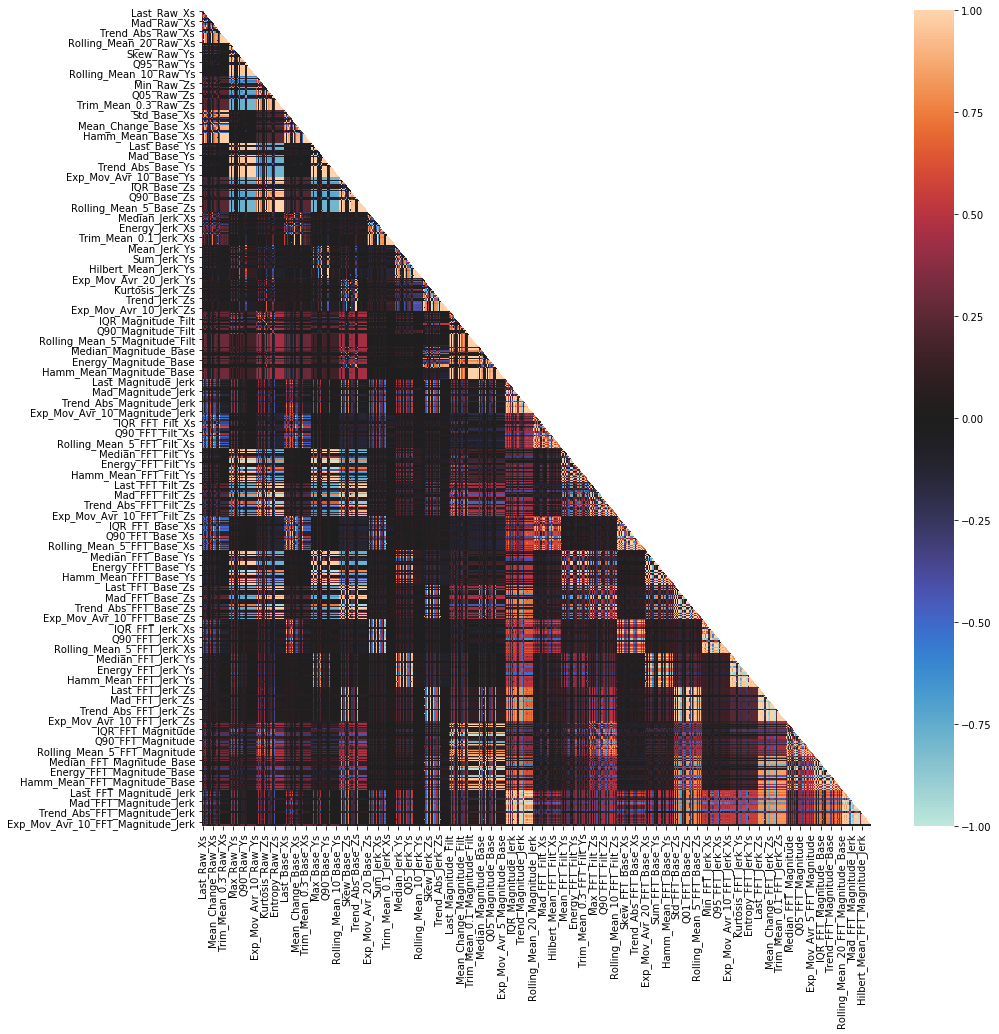

In [38]:
display("Initial number of features {}".format(data.shape[1]))
display_correlation_matrix(data)

# Dropping Highly Correlated Features
- Highly correlated features may lead to redundant dimensions in dataset, but also correlation does not imply causation. So we need to choose carefully which features to drop.. 
- Threshold for that was picked experimentally, taking into consideration the extracted features

In [39]:
data = drop_highly_correlated_features(data, correlation_threshold = 0.999, drop_percentage = 0.75, verbose = False)

Length Features to drop for Threshold 0.999: 327


'Number of features after dropping HCF: 388'

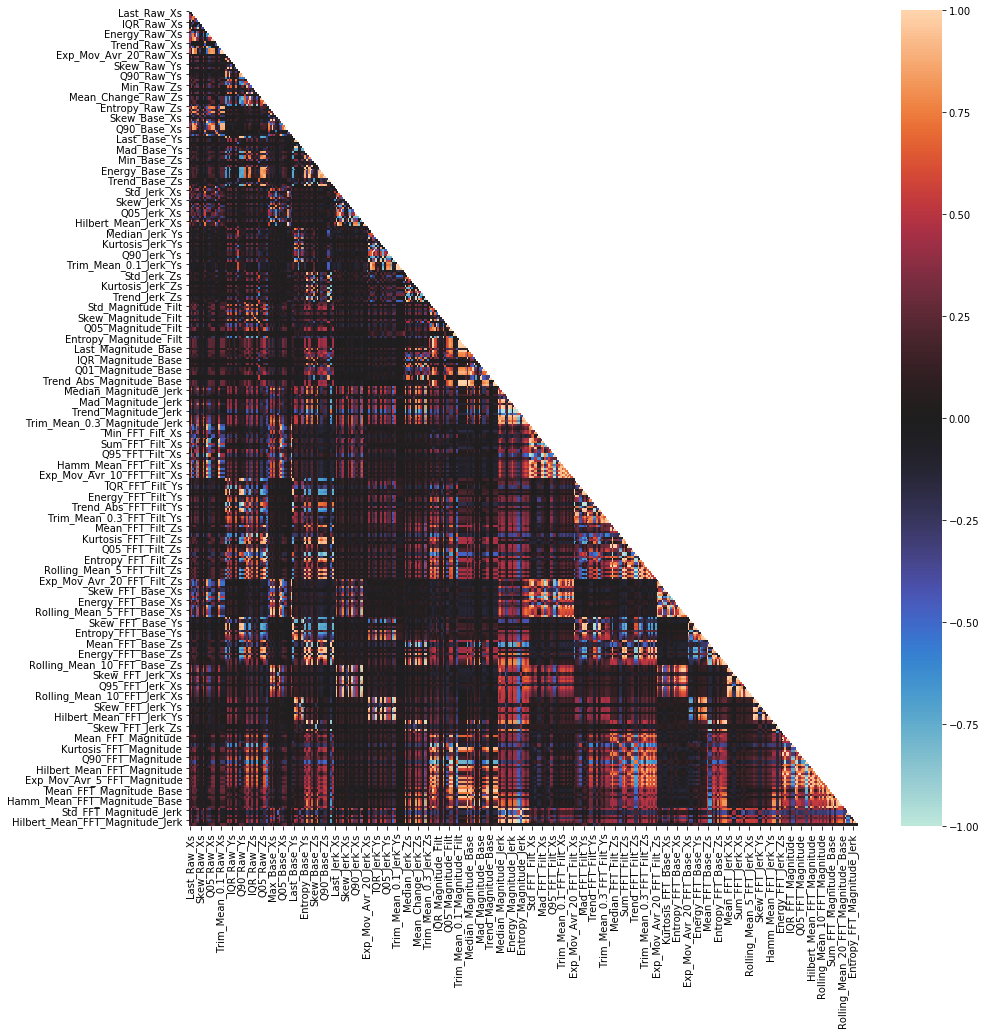

In [40]:
display("Number of features after dropping HCF: {}".format(data.shape[1]))
display_correlation_matrix(data)

In [41]:
data["Fold"] = folds

In [42]:
data.to_csv("dataset.csv", index = False)

data = pd.read_csv("dataset.csv")

# Training several models 
- This will develop a good intuition for a new baseline 
- And from those models will choose what models to optimize and use as "Level One" in a Multi-Layer Stacking Architecture

In [43]:
models = [LGBMClassifier, RandomForestClassifier, BaggingClassifier, SVC, HistGradientBoostingClassifier, ExtraTreesClassifier, LogisticRegression, GaussianNB]

names  = ["LGBM", "RandomForest", "Bagging", "SVC", "HistGradient", "ExtraTrees", "LogisticRegression", "GaussianNB"]

parameters = [
    # LGBM
    {
        'n_estimators': 500,
        'n_jobs': -1,
        'random_state' : seed,
    },
    # RandomForest
    {
        'n_estimators': 500,
        'n_jobs': -1,
        'random_state' : seed,
    },
    # Bagging
    {
        'base_estimator': SVC(C = 10, probability = True, cache_size = 2000, random_state = seed),
        'n_estimators': 100,
        'n_jobs': -1,
        'random_state' : seed,
    },
    # SVC
    {
        "C": 10,
        "probability": True,
        "random_state" : seed,
    },
    # HistGradient
    {
        
    },
    # ExtraTrees
    {
        'n_estimators': 500,
        'n_jobs': -1,
        'random_state' : seed,
    },
    # LogisiticRegression
    {
        'C': 10,
        'random_state' : seed,
    },
]

In [44]:
import warnings
warnings.filterwarnings("ignore")

features = data.drop(["Label", "Fold"], axis = 1).values
labels   = data["Label"].values 

for model, params, name in zip(models, parameters, names):
    y_oof    = np.zeros((features.shape[0], 1))
    y_true   = np.zeros((features.shape[0], 1))
    y_probas = np.zeros((features.shape[0], 20))

    fold_scores = np.zeros((FOLDS, 1))
    
    tic = timer.time()
    for fold in range(FOLDS):    
        print(20 * "!" + " FOLD {}, Model {} ".format(fold + 1, name) + "!" * 20)
        train_idx = data[data.Fold != fold].index.values
        valid_idx = data[data.Fold == fold].index.values

        X_train, y_train = features[train_idx], labels[train_idx]
        X_valid, y_valid = features[valid_idx], labels[valid_idx]

        scaler = MinMaxScaler()
        scaler.fit(X_train, y_train)

        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)

        model_ = model(**params)

        model_.fit(X_train, y_train)

        y_preds = model_.predict(X_valid)
        y_proba = model_.predict_proba(X_valid)

        y_oof[valid_idx]    = copy.deepcopy(np.expand_dims(y_preds, axis = 1))
        y_true[valid_idx]   = copy.deepcopy(np.expand_dims(y_valid, axis = 1))
        y_probas[valid_idx] = copy.deepcopy(y_proba)
        
        accuracy = accuracy_score(y_preds, y_valid)

        fold_scores[fold] = accuracy 

    oof_accuracy = np.round(accuracy_score(y_true, y_oof), 4)
    
    toc = timer.time()
    
    data["{}_Probas".format(name)] = [y_probas[i].argmax() + y_probas[i][y_probas[i].argmax()] for (i, _) in enumerate(y_probas)]
    
    print("Training {} in {}'s".format(name, (toc - tic)))
    print("{}: OOF Accuracy {}, Standard deviation OOF Scores {}," \
      .format(name, oof_accuracy, np.round(fold_scores.std(), 4)))

!!!!!!!!!!!!!!!!!!!! FOLD 1, Model LGBM !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 2, Model LGBM !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 3, Model LGBM !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 4, Model LGBM !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 5, Model LGBM !!!!!!!!!!!!!!!!!!!!
Training LGBM in 204.84868264198303's
LGBM: OOF Accuracy 0.9624, Standard deviation OOF Scores 0.0038,
!!!!!!!!!!!!!!!!!!!! FOLD 1, Model RandomForest !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 2, Model RandomForest !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 3, Model RandomForest !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 4, Model RandomForest !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 5, Model RandomForest !!!!!!!!!!!!!!!!!!!!
Training RandomForest in 47.74625563621521's
RandomForest: OOF Accuracy 0.9361, Standard deviation OOF Scores 0.0042,
!!!!!!!!!!!!!!!!!!!! FOLD 1, Model Bagging !!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!! FOLD 2, Model Bagging !!!!!!!!!!!!!!!!!!!!
!

In [45]:
data.to_csv("baseline_preds.csv", index = False)

data = pd.read_csv("baseline_preds.csv")

# Picking the best models
- The first criterion will use for this will be accuracy, of course, but actually the second one is more interesting
- The models will now pick represent the first layer of classifiers in a stacking architecture.
- As presented here: https://mlwave.com/kaggle-ensembling-guide/
- We need to have our models as "different" as possible, and from that..
- The second criterion will be the level of correlation between predictions of the initial models, and from that averaging or voting systems will have diversity and combined they will create better predictions

In [46]:
to_remove = [column for column in data.columns if column not in [name + "_Probas" for name in names]]

In [47]:
results = data.drop(to_remove, axis = 1, inplace = False)
display(results)

,LGBM_Probas,RandomForest_Probas,Bagging_Probas,SVC_Probas,HistGradient_Probas,ExtraTrees_Probas,LogisticRegression_Probas
0,6.999999,6.920,6.883436,6.938966,6.999997,6.822,6.560341
1,12.999990,12.858,12.942292,12.960322,12.999997,12.876,12.981682
2,6.000000,5.970,5.995916,5.998244,6.000000,5.988,5.999125
3,0.999955,0.838,0.886046,0.932639,0.999931,0.806,0.938713
4,0.999982,0.844,0.956315,0.976142,0.999942,0.830,0.965817
...,...,...,...,...,...,...,...
8995,20.000000,19.980,19.975770,19.987489,19.999999,19.940,19.998464
8996,1.995051,1.640,1.859426,1.954418,1.982241,1.510,1.671494
8997,12.628207,12.396,2.523963,2.730668,12.896831,12.354,2.556362
8998,2.999993,2.820,2.969895,2.982869,2.999962,2.754,2.991729


In [48]:
results.corr()

,LGBM_Probas,RandomForest_Probas,Bagging_Probas,SVC_Probas,HistGradient_Probas,ExtraTrees_Probas,LogisticRegression_Probas
LGBM_Probas,1.000000,0.958588,0.964209,0.961417,0.987295,0.963166,0.939618
RandomForest_Probas,0.958588,1.000000,0.949554,0.945620,0.956339,0.979420,0.928711
Bagging_Probas,0.964209,0.949554,1.000000,0.988961,0.962044,0.952106,0.955476
SVC_Probas,0.961417,0.945620,0.988961,1.000000,0.959384,0.948231,0.953201
HistGradient_Probas,0.987295,0.956339,0.962044,0.959384,1.000000,0.960104,0.938887
ExtraTrees_Probas,0.963166,0.979420,0.952106,0.948231,0.960104,1.000000,0.930334
LogisticRegression_Probas,0.939618,0.928711,0.955476,0.953201,0.938887,0.930334,1.000000


In [49]:
clfs = drop_highly_correlated_predictions(results, threshold = 0.98)

Length Classifiers to drop for Threshold 0.98: 2


In [50]:
clf_names = [name[:-7] for name in clfs.columns.values]
print("Classifers picked: ", clf_names)

Classifers picked:  ['LGBM', 'RandomForest', 'Bagging', 'ExtraTrees', 'LogisticRegression']


In [51]:
display(clfs.corr())

,LGBM_Probas,RandomForest_Probas,Bagging_Probas,ExtraTrees_Probas,LogisticRegression_Probas
LGBM_Probas,1.000000,0.958588,0.964209,0.963166,0.939618
RandomForest_Probas,0.958588,1.000000,0.949554,0.979420,0.928711
Bagging_Probas,0.964209,0.949554,1.000000,0.952106,0.955476
ExtraTrees_Probas,0.963166,0.979420,0.952106,1.000000,0.930334
LogisticRegression_Probas,0.939618,0.928711,0.955476,0.930334,1.000000


In [52]:
to_drop = [column for column in data.columns if column in [name + "_Probas" for name in names]]
data.drop(to_drop, axis = 1, inplace = True)
data

,Last_Raw_Xs,Std_Raw_Xs,Median_Raw_Xs,Max_Raw_Xs,Min_Raw_Xs,IQR_Raw_Xs,Skew_Raw_Xs,Kurtosis_Raw_Xs,Mad_Raw_Xs,Mean_Change_Raw_Xs,...,Exp_Mov_Avr_20_FFT_Magnitude_Base,Std_FFT_Magnitude_Jerk,Skew_FFT_Magnitude_Jerk,Kurtosis_FFT_Magnitude_Jerk,Energy_FFT_Magnitude_Jerk,Entropy_FFT_Magnitude_Jerk,Hilbert_Mean_FFT_Magnitude_Jerk,Rolling_Mean_5_FFT_Magnitude_Jerk,Label,Fold
0,0.449145,0.533116,0.226443,1.018421,-0.793549,0.726996,-0.419332,-0.904534,0.427084,0.007650,...,55.482055,14.801762,7.508242,59.800291,228.071673,2.450395,8.491442,1.811126,7.0,0
1,0.580978,0.597218,0.218270,1.092890,-1.021546,1.032462,-0.309386,-1.126218,0.515037,0.010079,...,59.779779,18.625833,7.349256,58.036576,367.384580,2.759661,11.295759,2.936646,13.0,0
2,-2.040514,0.848204,-1.955926,-0.010595,-2.602136,1.490398,0.653367,-1.103101,0.736780,-0.011406,...,54.177171,22.646307,7.592095,60.826735,529.396740,2.222504,12.610451,2.338088,6.0,0
3,-0.854091,0.626517,-0.528942,0.557194,-1.653033,1.190126,0.183676,-1.213225,0.545236,-0.006521,...,55.979866,14.551902,7.741772,64.103803,224.546403,2.825661,8.785373,2.376765,1.0,0
4,-1.281406,0.821502,0.017085,0.680491,-1.808822,1.573274,-0.321100,-1.517230,0.764148,-0.008056,...,55.789973,14.283867,8.094866,68.915409,213.274248,2.628000,8.196219,1.945285,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,-0.390584,0.517592,-0.404662,0.871147,-1.201801,0.688601,0.396533,-0.579163,0.419978,-0.002478,...,57.507525,15.545405,6.937183,52.396521,260.680857,2.954697,9.977347,2.964758,20.0,4
8996,-0.108431,0.549813,-0.293379,0.835049,-1.451953,0.719240,0.051558,-0.421184,0.440563,-0.000686,...,55.357085,20.593242,7.137054,54.936018,451.267936,2.806530,12.721708,3.417734,2.0,4
8997,0.150718,0.645637,-0.432893,0.715715,-1.429457,1.166655,0.090335,-1.264507,0.556924,-0.002588,...,60.999087,36.807011,6.566537,46.596427,1466.369948,2.960800,23.986787,7.182416,3.0,4
8998,-0.001747,0.659981,-0.015282,1.050524,-1.006734,1.302909,-0.014289,-1.498806,0.592587,-0.002208,...,61.424793,19.074692,6.547489,46.664667,395.998749,3.011446,12.601118,3.905023,3.0,4


# Bayesian Oprimization
- Now that we have the models, we need find the right hyper-parameters for them
- Bayesian Optimization would require a longer explanation, but the main reason to use this is because...
- In contrast to other hyper-optimization searching procedures, like GridSearch, RandomSearch.. that do not use knowledge from the previous experiments, the bayesian search uses a Expected Improvement function that guides the search, obtaining better results in larger hyper-parameters spaces in much less time

In [53]:
def train(model, parameters, scaler):
    features = data.drop(["Label", "Fold"], axis = 1).values
    labels   = data["Label"].values 
    
    y_oof    = np.zeros((features.shape[0], 1))
    y_true   = np.zeros((features.shape[0], 1))

    for fold in range(FOLDS):    

        train_idx = data[data.Fold != fold].index.values
        valid_idx = data[data.Fold == fold].index.values

        X_train, y_train = features[train_idx], labels[train_idx]
        X_valid, y_valid = features[valid_idx], labels[valid_idx]
        
        scaler_ = scaler
        scaler_.fit(X_train, y_train)

        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)
        
        model_ = model(**parameters)
        
        model_.fit(X_train, y_train)
        
        y_preds = model_.predict(X_valid)

        y_oof[valid_idx]    = copy.deepcopy(np.expand_dims(y_preds, axis = 1))
        y_true[valid_idx]   = copy.deepcopy(np.expand_dims(y_valid, axis = 1))

      
    oof_accuracy = np.round(accuracy_score(y_true, y_oof), 4)
    
    return oof_accuracy

In [54]:
def train_random_forest(n_estimators, min_samples_split):
    model = RandomForestClassifier
    scaler = MinMaxScaler()
    
    params = {
        'n_estimators': int(n_estimators),
        'min_samples_split': int(min_samples_split),
        'n_jobs': -1,
        'random_state': seed
    }
    
    accuracy = train(model, params, scaler)
    
    return accuracy

def train_extra_trees(n_estimators, max_depth, min_samples_split):
    model = ExtraTreesClassifier
    scaler = MinMaxScaler()
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'n_jobs': -1,
        'random_state': seed
    }
    
    accuracy = train(model, params, scaler)
    
    return accuracy

def train_logistic_regression(C, tol):
    model = LogisticRegression
    scaler = MinMaxScaler()
    
    params = {
        'C': C,
        'tol': tol,
        'n_jobs': -1,
        'random_state': seed
    }
    
    accuracy = train(model, params, scaler)
    
    return accuracy

def train_bagging_svm(C, n_estimators, max_features, max_samples):
    model = BaggingClassifier
    base_estimator = SVC(C = C)
    scaler = MinMaxScaler()
    
    params = {
        'base_estimator': base_estimator,
        'n_estimators': int(n_estimators),
        'max_features': max_features,
        'max_samples': max_samples,
        'n_jobs': -1,
        'random_state': seed
    }
    
    accuracy = train(model, params, scaler)
    
    return accuracy

def train_lgbm(n_estimators, learning_rate, colsample_bytree, subsample, reg_lambda):
    model = LGBMClassifier
    scaler = MinMaxScaler()
    
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_lambda': reg_lambda,
        'n_jobs': -1,
        'random_state': seed
    }
    
    accuracy = train(model, params, scaler)
    
    return accuracy
    

In [55]:
def Optimize(functions, bounds, names, init_points = 32, iterations = 64):
    tic = timer.time()
    
    for function, restrictions, name in zip(functions, bounds, names):
        print("Optimizing {}...".format(name))
        optimizer = BayesianOptimization(function, restrictions, random_state = seed)
        optimizer.maximize(init_points = init_points, n_iter = iterations, acq='ucb', xi=0.0, alpha=1e-6)
        
        results = open("{}_Parameters.pickle".format(name),"wb")
        pickle.dump(optimizer.max, results)
        results.close()
        
    toc = timer.time()
    print("Time to optimize {}'s'".format(toc - tic))

In [56]:
functions = [
    train_random_forest,
    train_extra_trees,
    train_logistic_regression,
    train_bagging_svm,
    train_lgbm
]

bounds = [
    # RandomForest
    {
        'n_estimators': (100, 700),
        'min_samples_split': (2, 6),
    },
    # ExtraTrees
    {
        'n_estimators': (100, 800),
        'max_depth': (30, 300),
        'min_samples_split': (2, 4),
    },
    # Logisticregression
    {
        'C':   (0, 100),
        'tol': (1e-4, 1e-5)
    },
    # Bagging SVM
    {
        'C':  (0, 100),
        'n_estimators': (10, 100),
        'max_features': (0.6, 1),
        'max_samples': (0.6, 1),
    },
    # LGBM
    {
        'n_estimators': (100, 1000),
        'learning_rate': (0.0001, 0.5),
        'subsample': (0.00001, 1.0),
        'colsample_bytree': (0.00001, 1.0),
        'reg_lambda': (0.01, 10)
    }

]

names = [
    "RandomForest",
    "ExtraTrees",
    "LogisticRegression",
    "BaggingSVM",
    'LGBM'
]


In [57]:
Optimize(functions, bounds, names)

Optimizing RandomForest...
|   iter    |  target   | min_sa... | n_esti... |
-------------------------------------------------
|  1        |  0.9356   |  3.004    |  127.7    |
|  2        |  0.9354   |  4.707    |  126.1    |
|  3        |  0.9363   |  2.466    |  462.3    |
|  4        |  0.9361   |  2.764    |  501.1    |
|  5        |  0.9351   |  5.67     |  351.3    |
|  6        |  0.9358   |  3.329    |  269.8    |
|  7        |  0.9351   |  2.745    |  290.3    |
|  8        |  0.9353   |  3.925    |  141.7    |
|  9        |  0.9354   |  4.82     |  288.8    |
|  10       |  0.9354   |  4.981    |  338.9    |
|  11       |  0.935    |  4.433    |  537.1    |
|  12       |  0.9362   |  3.687    |  336.3    |
|  13       |  0.9361   |  2.929    |  365.0    |
|  14       |  0.936    |  3.492    |  450.2    |
|  15       |  0.9361   |  2.4      |  544.8    |
|  16       |  0.9349   |  2.333    |  175.7    |
|  17       |  0.9359   |  3.292    |  485.8    |
|  18       |  0.9346  

|  1        |  0.9416   |  97.75    |  2.092    |  573.8    |
|  2        |  0.9419   |  41.74    |  2.233    |  522.7    |
|  3        |  0.9423   |  81.55    |  3.337    |  742.2    |
|  4        |  0.9406   |  143.1    |  2.665    |  298.1    |
|  5        |  0.9419   |  80.3     |  2.634    |  436.8    |
|  6        |  0.9418   |  48.77    |  3.41     |  320.3    |
|  7        |  0.9419   |  231.2    |  2.796    |  525.8    |
|  8        |  0.9414   |  226.7    |  2.844    |  375.7    |
|  9        |  0.9408   |  92.7     |  2.883    |  361.1    |
|  10       |  0.9414   |  187.6    |  2.2      |  618.9    |
|  11       |  0.941    |  52.46    |  2.252    |  326.0    |
|  12       |  0.9418   |  203.6    |  3.999    |  296.7    |
|  13       |  0.9419   |  187.2    |  3.745    |  652.5    |
|  14       |  0.9419   |  88.88    |  2.693    |  605.1    |
|  15       |  0.94     |  125.6    |  2.921    |  271.1    |
|  16       |  0.9422   |  106.3    |  3.653    |  712.1    |
|  17   

|  82       |  0.9418   |  33.7     |  2.554    |  794.2    |
|  83       |  0.9418   |  299.7    |  3.766    |  799.1    |
|  84       |  0.9417   |  33.77    |  2.708    |  799.8    |
|  85       |  0.9416   |  32.82    |  3.328    |  798.4    |
|  86       |  0.9419   |  297.0    |  2.279    |  798.9    |
|  87       |  0.9418   |  298.0    |  3.052    |  799.9    |
|  88       |  0.9416   |  31.75    |  2.302    |  799.8    |
|  89       |  0.9417   |  299.3    |  2.815    |  797.5    |
|  90       |  0.9418   |  290.5    |  2.126    |  799.5    |
|  91       |  0.9418   |  299.3    |  3.569    |  799.9    |
|  92       |  0.9418   |  33.62    |  2.231    |  796.1    |
|  93       |  0.9417   |  32.98    |  3.304    |  799.3    |
|  94       |  0.9419   |  296.2    |  2.432    |  798.8    |
|  95       |  0.9418   |  298.5    |  2.258    |  800.0    |
|  96       |  0.9417   |  294.8    |  3.086    |  794.9    |
Optimizing LogisticRegression...
|   iter    |  target   |     C     |

|  80       |  0.9329   |  99.93    |  1e-05    |
|  81       |  0.932    |  99.88    |  1e-05    |
|  82       |  0.9308   |  99.92    |  1e-05    |
|  83       |  0.9329   |  99.62    |  1e-05    |
|  84       |  0.9312   |  99.36    |  1e-05    |
|  85       |  0.931    |  99.97    |  1e-05    |
|  86       |  0.9326   |  99.95    |  1e-05    |
|  87       |  0.931    |  99.87    |  1e-05    |
|  88       |  0.9309   |  99.93    |  1e-05    |
|  89       |  0.9333   |  99.71    |  1e-05    |
|  90       |  0.9292   |  99.91    |  1e-05    |
|  91       |  0.9311   |  99.73    |  1e-05    |
|  92       |  0.9304   |  99.83    |  1e-05    |
|  93       |  0.9318   |  100.0    |  1e-05    |
|  94       |  0.9293   |  99.49    |  1e-05    |
|  95       |  0.9321   |  99.86    |  1e-05    |
|  96       |  0.9327   |  99.58    |  1e-05    |
Optimizing BaggingSVM...
|   iter    |  target   |     C     | max_fe... | max_sa... | n_esti... |
---------------------------------------------------

|  55       |  0.9622   |  47.63    |  0.6044   |  0.9984   |  45.19    |
|  56       |  0.9617   |  99.14    |  0.6057   |  0.9914   |  33.69    |
|  57       |  0.9611   |  32.85    |  0.6007   |  0.9983   |  61.33    |
|  58       |  0.962    |  47.35    |  0.6149   |  0.9907   |  40.52    |
|  59       |  0.9616   |  88.35    |  0.6093   |  0.9997   |  45.16    |
|  60       |  0.9621   |  89.46    |  0.6176   |  0.9974   |  25.7     |
|  61       |  0.9616   |  76.6     |  0.6059   |  0.9993   |  44.18    |
|  62       |  0.9617   |  46.3     |  0.6178   |  0.9962   |  44.21    |
|  63       |  0.9618   |  88.79    |  0.6078   |  0.9934   |  27.63    |
|  64       |  0.9606   |  66.59    |  0.6077   |  0.9975   |  55.29    |
|  65       |  0.9622   |  99.97    |  0.6044   |  0.9887   |  28.16    |
|  66       |  0.9603   |  51.66    |  0.6117   |  0.9992   |  88.36    |
|  67       |  0.9621   |  92.3     |  0.6125   |  0.9973   |  33.55    |
|  68       |  0.9622   |  76.08    | 

|  21       |  0.9573   |  0.6451   |  0.1765   |  425.5    |  3.231    |  0.1701   |
|  22       |  0.959    |  0.3396   |  0.2816   |  731.0    |  8.091    |  0.3431   |
|  23       |  0.9567   |  0.7602   |  0.1656   |  324.5    |  6.493    |  0.4104   |
|  24       |  0.9551   |  0.08504  |  0.2932   |  354.2    |  2.237    |  0.1871   |
|  25       |  0.9562   |  0.9831   |  0.04737  |  468.0    |  1.338    |  0.04445  |
|  26       |  0.9587   |  0.7091   |  0.4285   |  796.3    |  7.615    |  0.6709   |
|  27       |  0.9573   |  0.09202  |  0.3148   |  949.8    |  1.116    |  0.1498   |
|  28       |  0.9501   |  0.6006   |  0.007398 |  604.1    |  0.3313   |  0.2507   |
|  29       |  0.9544   |  0.29     |  0.02936  |  427.7    |  4.284    |  0.2316   |
|  30       |  0.957    |  0.9678   |  0.3702   |  499.4    |  4.983    |  0.2159   |
|  31       |  0.9527   |  0.722    |  0.4206   |  128.2    |  6.259    |  0.8911   |
|  32       |  0.9572   |  0.1842   |  0.03633  |  901

|  79       |  0.9604   |  0.7751   |  0.05777  |  999.8    |  0.09729  |  0.5124   |
|  80       |  0.9577   |  0.7367   |  0.4785   |  997.1    |  0.02265  |  0.8865   |
|  81       |  0.9597   |  0.5018   |  0.3591   |  999.7    |  0.06564  |  0.4713   |
|  82       |  0.9622   |  0.2369   |  0.1929   |  994.9    |  0.01891  |  0.6738   |
|  83       |  0.9584   |  0.945    |  0.4338   |  996.0    |  0.0818   |  0.04901  |
|  84       |  0.9576   |  0.9341   |  0.4218   |  998.6    |  0.07709  |  0.02937  |
|  85       |  0.957    |  0.09451  |  0.3619   |  999.3    |  0.06548  |  0.9123   |
|  86       |  0.9536   |  0.5528   |  0.006216 |  997.0    |  0.04524  |  0.611    |
|  87       |  0.9631   |  0.331    |  0.3248   |  998.6    |  0.03405  |  0.291    |
|  88       |  0.962    |  0.3102   |  0.4426   |  998.6    |  0.03369  |  0.9714   |
|  89       |  0.9619   |  0.6046   |  0.2384   |  999.1    |  0.09533  |  0.0557   |
|  90       |  0.961    |  0.8803   |  0.1636   |  992

# And now we have the hyper-parameters for the "Level One"
- We'll load them back into classifiers

In [71]:
names = [
    "RandomForest",
    "ExtraTrees",
    "LogisticRegression",
    "BaggingSVM",
    'LGBM'
]

results = []
for idx, name in enumerate(names):
    results_pickle = open("{}_Parameters.pickle".format(name), "rb")
    result = pickle.load(results_pickle)
    results.append(result)

In [72]:
for result in results:
    print(result)

{'target': 0.9372, 'params': {'min_samples_split': 2.1955789352523625, 'n_estimators': 699.684149131715}}
{'target': 0.9424, 'params': {'max_depth': 70.00349502604047, 'min_samples_split': 3.1254889128458174, 'n_estimators': 471.84124310535884}}
{'target': 0.9337, 'params': {'C': 99.96979401807448, 'tol': 1e-05}}
{'target': 0.9632, 'params': {'C': 90.19276727835224, 'max_features': 0.6043692641210917, 'max_samples': 0.9992819995552807, 'n_estimators': 23.877292306803636}}
{'target': 0.9631, 'params': {'colsample_bytree': 0.334365535754929, 'learning_rate': 0.24274978536773775, 'n_estimators': 999.9776814389535, 'reg_lambda': 0.05197668860372792, 'subsample': 0.49228201114984355}}


In [73]:
models = [RandomForestClassifier, ExtraTreesClassifier, LogisticRegression, BaggingClassifier, LGBMClassifier]

names = [
    "RandomForest",
    "ExtraTrees",
    "LogisticRegression",
    "BaggingSVM",
    'LGBM'
]

In [74]:
level_one = []

for idx, (name, model) in enumerate(zip(names, models)):
    
    if "n_estimators" in results[idx]["params"].keys():
        results[idx]["params"]["n_estimators"] = int(results[idx]["params"]["n_estimators"])
    
    if "max_depth" in results[idx]["params"].keys():
        results[idx]["params"]["max_depth"] = int(results[idx]["params"]["max_depth"])
        
    if "min_samples_split" in results[idx]["params"].keys():
        results[idx]["params"]["min_samples_split"] = int(results[idx]["params"]["min_samples_split"])
        
    results[idx]["params"]["n_jobs"] = -1
    results[idx]["params"]["random_state"] = seed
    
    if name == "BaggingSVM":
        
        params = {
            
            "base_estimator": SVC(results[idx]["params"]["C"], probability = True, random_state = seed),
            "max_features": results[idx]["params"]["max_features"],
            "max_samples": results[idx]["params"]["max_samples"],
            "n_estimators": int(results[idx]["params"]["n_estimators"]),
            "n_jobs": -1,
            "random_state": seed
            
        }
        
        results[idx]["params"] = params
        
#     print(name)
#     print(model(**results[idx]["params"]))
    
    level_one.append((name, model(**results[idx]["params"])))
        

# Stacking Multi-Level Classifier
- Stacking and blending represent advanced approaches that every top kagglers applies in competitions for improving results. 
- There is much to explain here, but a short summary is that we use predictions from a previous layer of various models as input for new layer. You can think a this as the dataset will be embedded in predictions from some classifiers/regressors/both forming the input of a new model.
- Done wrong can cause data leakage

Short Algorithm:

    1. We split the training data into K-folds just like K-fold cross-validation.
    2. A base model is fitted on the K-1 parts and predictions are made for Kth part.
    3. We do for each part of the training data.
    4. The base model is then fitted on the whole train data set to calculate its performance on the test set.
    5. We repeat the last 3 steps for other base models.
    6. Predictions from the train set are used as features for the second level model.
    7. Second level model is used to make a prediction on the test set.

- https://www.geeksforgeeks.org/stacking-in-machine-learning/


 For this Notebook I preferred to implement it myself for learning purposes and because I wanted to see a difference in scores compared with a voting system, but it's also implemented in Sklearn 0.22 as StackingClassifier

In [75]:
class MultiStackClassifier:
    def __init__(self, models: list, stack_level: int):
        self.models = models
        self.stack_level = stack_level
        
        assert stack_level == len(models), "Stack Level Fail"
    
    def predict(self, y, level, voting = False):
        level_predictions = np.zeros((y.shape[0], len(self.models[level])))
        for (idx, (name, model)) in enumerate(self.models[level]):
            preds = self.models[level][idx][1].predict(y)
            level_predictions[:, idx] = preds
        
        if voting:
            import operator
            votes = [dict(zip(*np.unique(vote, return_counts = True))) for vote in level_predictions]
            max_votes = [max(vote.items(), key = operator.itemgetter(1))[0] for vote in votes]
        
        return level_predictions
        
    def predict_proba(self, y, level):
        level_predictions = np.zeros((y.shape[0], len(self.models[level])))
        for (idx, (name, model)) in enumerate(self.models[level]):
            probas = self.models[level][idx][1].predict_proba(y)
            preds = [probas[i].argmax() + probas[i][probas[i].argmax()] for (i, _) in enumerate(probas)]
            level_predictions[:, idx] = preds
        
        return level_predictions

    def fit(self, X, y, level, verbose = False):
        for (idx, (name, model)) in enumerate(self.models[level]):
            if verbose:
                print("Training {}, Level {}".format(name, level))
            self.models[level][idx][1].fit(X, y)
            
    def compute_accuracy(self, y_pred, y_true, weights = None):
        
        scores = [np.round(accuracy_score(y_pred[:, idx], y_true), 4) for idx in range(y_pred.shape[1])]
        
        if weights is not None:
            assert weights != y_pred.shape[1], "Not enought weights"
            
            weighted_votes = np.zeros((y_pred.shape[0], sum(weights)))
            weighted_ = [y_pred[:, idx] for idx in range(y_pred.shape[1]) for _ in range(weights[idx])]
            
            for (idx, arr) in enumerate(weighted_):
                weighted_votes[:, idx] = arr
            
            y_pred = weighted_votes
            
        import operator
        votes = [dict(zip(*np.unique(vote, return_counts = True))) for vote in y_pred]
        max_votes = [max(vote.items(), key = operator.itemgetter(1))[0] for vote in votes]
        
        voting_score = np.round(accuracy_score(max_votes, y_true), 4)
        
        return scores, voting_score

In [76]:
from xgboost import XGBClassifier

stacking_models = [
    
    # Level 1
    level_one,
    
    # Level 2
    [
        ("XGBClassifier", XGBClassifier(n_jobs = -1, random_state = seed, learning_rate = 0.035))
    ]
    
]

In [77]:
print(stacking_models)

[[('RandomForest', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=699,
                       n_jobs=-1, oob_score=False, random_state=41, verbose=0,
                       warm_start=False)), ('ExtraTrees', ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=70, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=3,
                     min_weight_fraction_leaf=0.0, n_estimators=471, n_jobs=-1,


In [78]:
import warnings
warnings.filterwarnings("ignore")

features = data.drop(["Label", "Fold"], axis = 1).values
labels   = data["Label"].values 

y_oof    = np.zeros((features.shape[0], 1))
y_true   = np.zeros((features.shape[0], 1))

scores_oof = np.zeros((FOLDS, 1))

tic = timer.time()

stacks = []

LEVELS = 2
final_level = 1

weights = [[4, 4, 3, 7, 10], [1]]

for level in range(LEVELS):
    level_predictions = np.zeros((features.shape[0], len(stacking_models[level]))) 
    for fold in range(FOLDS):    
        print(20 * '!' + " Level {} / {}, Fold {} / {} ".format(level + 1, LEVELS, fold + 1, FOLDS) + "!" * 20)

        train_idx = data[data.Fold != fold].index.values
        valid_idx = data[data.Fold == fold].index.values

        X_train, y_train = features[train_idx], labels[train_idx]
        X_valid, y_valid = features[valid_idx], labels[valid_idx]
        
        scaler = MinMaxScaler()
        scaler.fit(X_train, y_train)

        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)

        stack = MultiStackClassifier(models = stacking_models, stack_level = LEVELS)

        stack.fit(X = X_train, y = y_train, level = level)
        
        y_preds = stack.predict(X_valid, level = level, voting = False)
        
        scores, voting_score = stack.compute_accuracy(y_preds, y_valid, weights = weights[level])     
        
        for idx, (name, model) in enumerate(stacking_models[level]):
            print("Model {}, Level {} with Accuracy {}".format(name, level + 1, scores[idx]))
        
        if level != final_level:
            print("Level Voting Accuracy for Fold {}: {} ".format(fold, voting_score))
        
        
        level_probs = stack.predict_proba(X_valid, level = level)
        level_predictions[valid_idx] = copy.deepcopy(level_probs)
        
        if level == final_level:
            stacks.append(stack)
            y_oof[valid_idx, :]    = copy.deepcopy(y_preds)
            y_true[valid_idx, :]   = copy.deepcopy(np.expand_dims(y_valid, axis = 1))
    
    features = level_predictions
    
    if level == 0:
        save_oof = {
            "features": features,
            "labels": labels
        }

        pickle_out = open("save_oof.pickle", "wb")
        pickle.dump(save_oof, pickle_out)
        pickle_out.close()


toc = timer.time()
print("Time to train {}'s'".format(toc - tic))

!!!!!!!!!!!!!!!!!!!! Level 1 / 2, Fold 1 / 5 !!!!!!!!!!!!!!!!!!!!
Model RandomForest, Level 1 with Accuracy 0.9428
Model ExtraTrees, Level 1 with Accuracy 0.9478
Model LogisticRegression, Level 1 with Accuracy 0.9344
Model BaggingSVM, Level 1 with Accuracy 0.9633
Model LGBM, Level 1 with Accuracy 0.9694
Level Voting Accuracy for Fold 0: 0.9667 
!!!!!!!!!!!!!!!!!!!! Level 1 / 2, Fold 2 / 5 !!!!!!!!!!!!!!!!!!!!
Model RandomForest, Level 1 with Accuracy 0.94
Model ExtraTrees, Level 1 with Accuracy 0.9456
Model LogisticRegression, Level 1 with Accuracy 0.9317
Model BaggingSVM, Level 1 with Accuracy 0.9567
Model LGBM, Level 1 with Accuracy 0.9622
Level Voting Accuracy for Fold 1: 0.9611 
!!!!!!!!!!!!!!!!!!!! Level 1 / 2, Fold 3 / 5 !!!!!!!!!!!!!!!!!!!!
Model RandomForest, Level 1 with Accuracy 0.94
Model ExtraTrees, Level 1 with Accuracy 0.9439
Model LogisticRegression, Level 1 with Accuracy 0.9356
Model BaggingSVM, Level 1 with Accuracy 0.9611
Model LGBM, Level 1 with Accuracy 0.965
Level 

In [79]:
features_file = open("save_oof.pickle", "rb")
features_dict = pickle.load(features_file)
features_dict

{'features': array([[ 6.91559371,  6.80997877,  6.7198062 ,  6.87497758,  6.99998379],
        [12.87124464, 12.88004246, 12.99113599, 12.92987848, 12.99997273],
        [ 5.97711016,  5.98619958,  5.99979431,  5.99467541,  5.99999959],
        ...,
        [12.39055794, 12.37685775, 12.52614993,  2.47873361, 12.98579934],
        [ 2.81545064,  2.73354565,  2.99755409,  2.94676844,  2.99998727],
        [17.981402  , 17.97346072, 17.99920927, 17.98088609, 17.99999981]]),
 'labels': array([ 7., 13.,  6., ...,  3.,  3., 18.])}

# The Final Results
- It seems that the stacking architecture gives better results than the voting system
- This result is much better than the ones from the previous solution

In [80]:
print("Final Accuracy is {}".format(accuracy_score(y_true, y_oof)))

Final Accuracy is 0.9657777777777777


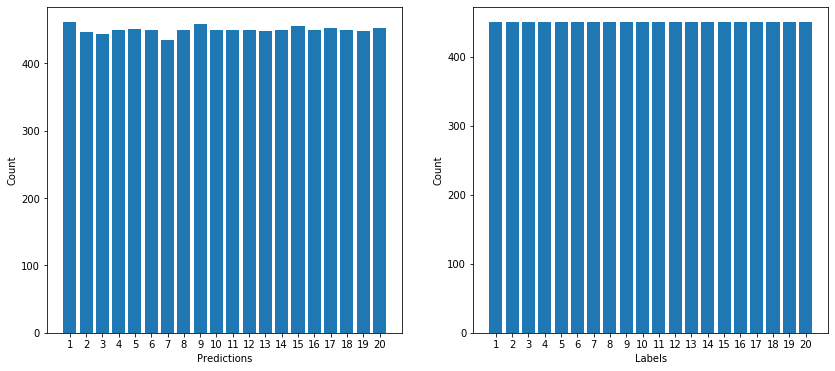

In [81]:
preds  , counts_preds = np.unique(y_oof, return_counts=True)
classes, counts_class = np.unique(y_true, return_counts=True)

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax1.bar(preds, counts_preds, align='center')
plt.gca().set_xticks(classes)
plt.xlabel("Predictions")
plt.ylabel("Count")

ax2 = fig.add_subplot(122)
ax2.bar(classes, counts_class, align='center')
plt.gca().set_xticks(classes)
plt.xlabel("Labels")
plt.ylabel("Count")

plt.show()

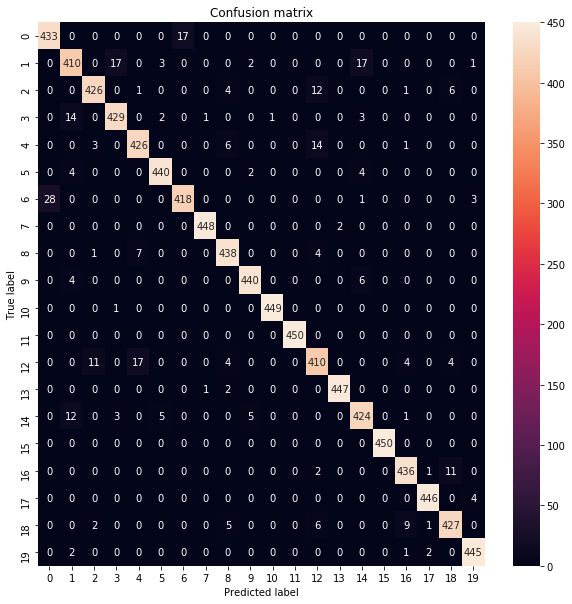

In [82]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_true, y_oof)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [83]:
print(classification_report(y_true, y_oof))

              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       450
         2.0       0.92      0.91      0.92       450
         3.0       0.96      0.95      0.95       450
         4.0       0.95      0.95      0.95       450
         5.0       0.94      0.95      0.95       450
         6.0       0.98      0.98      0.98       450
         7.0       0.96      0.93      0.94       450
         8.0       1.00      1.00      1.00       450
         9.0       0.95      0.97      0.96       450
        10.0       0.98      0.98      0.98       450
        11.0       1.00      1.00      1.00       450
        12.0       1.00      1.00      1.00       450
        13.0       0.92      0.91      0.91       450
        14.0       1.00      0.99      0.99       450
        15.0       0.93      0.94      0.94       450
        16.0       1.00      1.00      1.00       450
        17.0       0.96      0.97      0.97       450
        18.0       0.99    